# Getting Started with the Wildfires Dataset

*Margriet Groenendijk, Asad Memood and Vinay Kumar, November 2020*

### Call for Code Spot Challenge on Wildfires

* This notebook is presented at the [Digital Developer Conference](http://ibm.biz/devcon-ai)
* Find the contest description on this [page](http://ibm.biz/cfcsc-wildfires)
* Details about the data, example notebooks and other resources are in this [GitHub repo](https://github.com/Call-for-Code/Spot-Challenge-Wildfires)
* Find the contest leaderboard [here](http://ibm.biz/cfcsc-wildfires-lead)
* Ask questions and find a team in the #cfcsc-wildfires [Call for Code Slack channel](http://callforcode.slack.com)

### Predicting Wildfires

* The ultimate goal of the challenge is to **predict the area of wildfires in 7 regions in Australia for February 2021** with historical data, so you will be predicting fires before they have happened! 
* The final submissions will be **on 31 January 2021**.
* But until then you can work on your model with the below data and any other open datasets that you think might be relevant.
* Before the final submission there will be three prediction submissions to first predict the wildfires in February 2020, and then for the third and fourth week of January. This will give you time to improve your model before the final submission.

### In this notebook

[1. Data Introduction](#data)

* [1.1 Historical Wildfires](#data1)
* [1.2 Historical Weather](#data2)
* [1.3 Historical Vegetation Index](#data3)
* [1.4 Historical Weather Forecasts](#data4)
        
[2. Data Exploration](#exploration)

* [2.1 Data Distributions](#exp1)
* [2.2 Correlations](#exp2)

[3. Models](#predictions)

* [3.1 Linear regression model](#model1)
* [3.2 Decision tree model](#model2)

[4. Next steps](#next)


<a class="anchor" id="data"></a>
## 1. Data Introduction

> **Find a detailed description of the data provided for the challenge in the readme document in the [GitHub repo](https://github.com/Call-for-Code/Spot-Challenge-Wildfires)**

<a class="anchor" id="data1"></a>
### 1.1 Historical Wildfires


This wildfire dataset contains data on fire activities in Australia starting from 2005. Additional information can be found [here](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/c6-mcd14dl). For this competition, all MCD14DL data was further processed by using [IBM PAIRS Geoscope](https://ibmpairs.mybluemix.net/).

#### Variables 

* `Region`: the 7 regions
* `Date`: in UTC and provide the data for 24 hours ahead
* `Estimated_fire_area`: daily sum of estimated fire area for presumed vegetation fires with a confidence > 75% for a each region in km$^2$
* `Mean_estimated_fire_brightness`: daily mean (by flagged fire pixels(=count)) of estimated fire brightness for presumed vegetation fires with a confidence level > 75% in Kelvin
* `Mean_estimated_fire_radiative_power`: daily mean of estimated radiative power for presumed vegetation fires with a confidence level > 75% for a given region in megawatts
* `Mean_confidence`: daily mean of confidence for presumed vegetation fires with a confidence level > 75% 
* `Std_confidence`: standard deviation of estimated fire radiative power in megawatts
* `Var_confidence`: Variance of estimated fire radiative power in megawatts
* `Count`: daily numbers of pixels for presumed vegetation fires with a confidence level of larger than 75% for a given region
* `Replaced`: Indicates with an `Y` whether the data has been replaced with standard quality data when they are available (usually with a 2-3 month lag). Replaced data has a slightly higher quality in terms of locations

#### Load packages

In [1]:
!conda install pandas==1.1.3
!conda install seaborn==0.11.0

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [2]:
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline

#### Download data from github

In [3]:
!wget -N https://raw.githubusercontent.com/Call-for-Code/Spot-Challenge-Wildfires/main/data/Nov_10.zip
zip = zipfile.ZipFile("Nov_10.zip")
zip.extractall()

--2020-11-09 18:18:46--  https://raw.githubusercontent.com/Call-for-Code/Spot-Challenge-Wildfires/main/data/Nov_10.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18988121 (18M) [application/zip]
Saving to: ‘Nov_10.zip’

Nov_10.zip          100%[===================>]  18.11M  53.5MB/s    in 0.3s    

Last-modified header missing -- time-stamps turned off.
2020-11-09 18:18:47 (53.5 MB/s) - ‘Nov_10.zip’ saved [18988121/18988121]



In [4]:
!ls -l Nov_10

total 55500
-rw-r----- 1 wsuser watsonstudio 28599724 Nov  9 18:18 HistoricalWeather.csv
-rw-r----- 1 wsuser watsonstudio 26072107 Nov  9 18:18 HistoricalWeatherForecasts.csv
-rw-r----- 1 wsuser watsonstudio  2048982 Nov  9 18:18 Historical_Wildfires.csv
-rw-r----- 1 wsuser watsonstudio      813 Nov  9 18:18 LandClass.csv
-rw-r----- 1 wsuser watsonstudio    98276 Nov  9 18:18 VegetationIndex.csv


#### Load wildfires data

* This file contains the `Estimated_fire_area` that you can use as the labels to train your model with
* You can use the other columns as features in your model

In [5]:
file_wildfires = "Nov_10/Historical_Wildfires.csv"
wildfires_df = pd.read_csv(file_wildfires)
wildfires_df['Date'] = pd.to_datetime(wildfires_df['Date'])
wildfires_df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [6]:
wildfires_df.dtypes

Region                                         object
Date                                   datetime64[ns]
Estimated_fire_area                           float64
Mean_estimated_fire_brightness                float64
Mean_estimated_fire_radiative_power           float64
Mean_confidence                               float64
Std_confidence                                float64
Var_confidence                                float64
Count                                           int64
Replaced                                       object
dtype: object

In [7]:
wildfires_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Estimated_fire_area,26406.0,144.297966,314.453847,1.0,8.911875,38.434091,146.951278,10120.943170
Mean_estimated_fire_brightness,26406.0,319.662078,8.862005,290.7,313.933333,319.784412,325.403144,381.950000
Mean_estimated_fire_radiative_power,26406.0,83.621258,67.510022,0.0,44.150391,67.133333,103.123611,2178.600000
Mean_confidence,26406.0,87.574735,4.371972,76.0,85.000000,87.771429,90.498403,100.000000
Std_confidence,24199.0,7.228302,1.995221,0.0,6.687010,7.707025,8.236665,16.970563
Var_confidence,24199.0,56.229092,25.898935,0.0,44.716106,59.398234,67.842642,288.000000
Count,26406.0,72.059305,150.973128,1.0,5.000000,20.000000,74.000000,3954.000000


In [8]:
print("Number of records: {}".format(len(wildfires_df)))
print("Number of regions: {}\n".format(len(wildfires_df['Region'].unique())))
print(wildfires_df['Region'].unique())

Number of records: 26406
Number of regions: 7

['NSW' 'NT' 'QL' 'SA' 'TA' 'VI' 'WA']


In [9]:
# check for missing values
wildfires_df.isna().sum()

Region                                    0
Date                                      0
Estimated_fire_area                       0
Mean_estimated_fire_brightness            0
Mean_estimated_fire_radiative_power       0
Mean_confidence                           0
Std_confidence                         2207
Var_confidence                         2207
Count                                     0
Replaced                                  0
dtype: int64

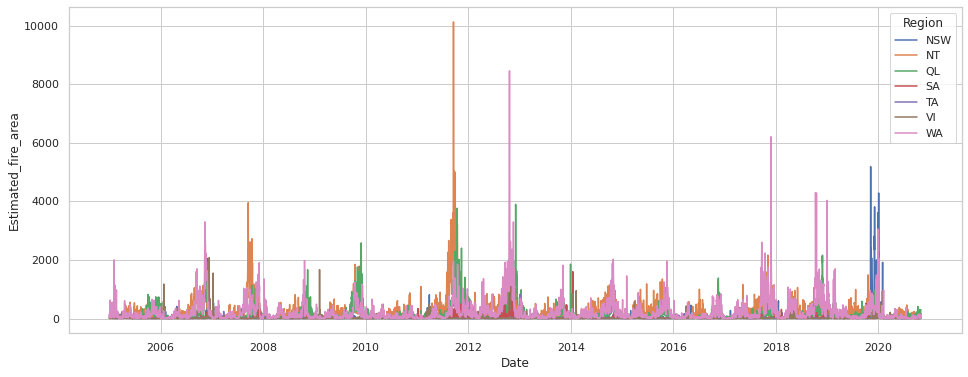

In [10]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region', data=wildfires_df)

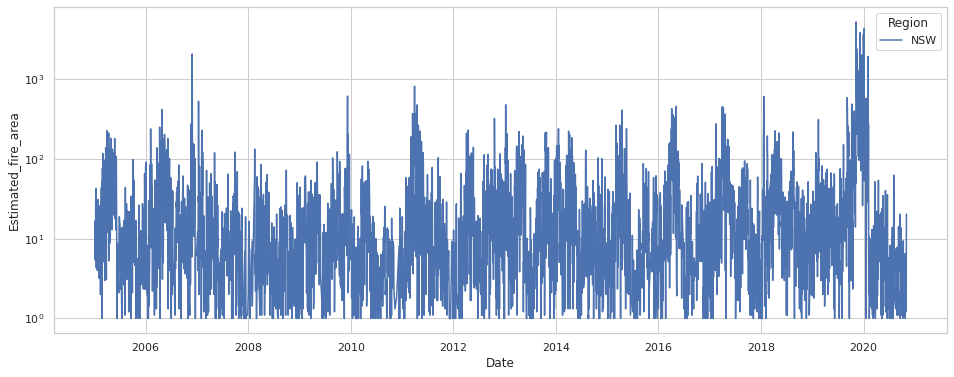

In [11]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Estimated_fire_area",hue='Region',
                 data=wildfires_df[wildfires_df['Region']=='NSW'])
g.set_yscale("log")

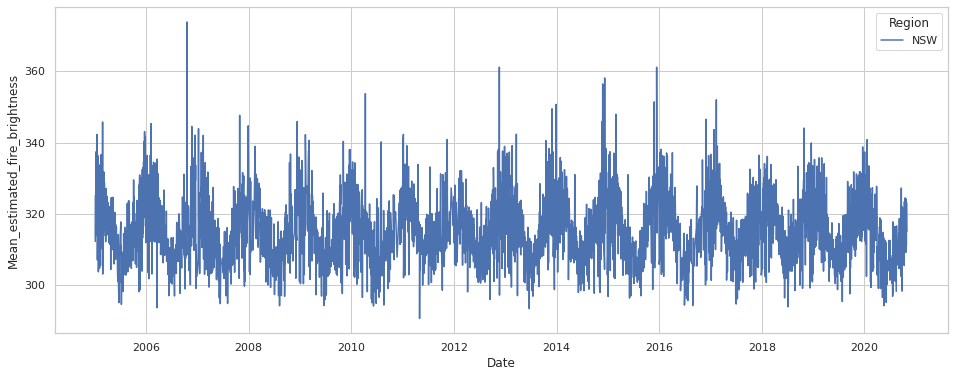

In [12]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Mean_estimated_fire_brightness",hue='Region',
                 data=wildfires_df[wildfires_df['Region']=='NSW'])

<a class="anchor" id="data2"></a>
### 1.2 Historical Weather

This dataset contains daily aggregates computed from the hourly ERA5 climate reanalysis. Find more information about this data [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) and [here](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)

#### Variables

* All variables are aggregated to daily values from `YYYY-mm-ddT01:00:00Z` to `YYYY-mm-(dd+1)T00:00:00Z`
* `Precipitation` is derived from total precipitation. Hourly raw data is converted from m/hour to mm/hour 
* [`Relative humidity`](https://en.wikipedia.org/wiki/Relative_humidity) is derived from the temperature and dewpoint
* `Soil water content` is given for 0 - 7 cm below the surface
* `Solar radiation`or Surface Solar Radiation Downwards. Units are converted from J/h to MJ/h
* `Temperature`
* `Wind speed` is calculated for every hour from the Easterly and Northerly 10 meter wind components

In [13]:
file_weather = "Nov_10/HistoricalWeather.csv"
weather_df = pd.read_csv(file_weather)

# rename columns
weather_df = weather_df.rename(columns={"count()[unit: km^2]": "Area", "min()": "Min",
                                       "max()": "Max", "mean()": "Mean", "variance()": "Variance"})

weather_df['Date'] = pd.to_datetime(weather_df['Date'])

weather_df.head()

,Date,Region,Parameter,Area,Min,Max,Mean,Variance
0,2005-01-01,NSW,Precipitation,800234.348986,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,800234.348986,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,800234.348986,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,800234.348986,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,800234.348986,14.485785,35.878704,27.341182,18.562212


In [14]:
print("Number of records: {}".format(len(weather_df)))
print("Number of regions: {}\n".format(len(weather_df['Region'].unique())))
print(weather_df['Region'].unique())

Number of records: 242781
Number of regions: 7

['NSW' 'NT' 'QL' 'SA' 'TA' 'VI' 'WA']


In [15]:
# check for missing values
weather_df.isna().sum()

Date         0
Region       0
Parameter    0
Area         0
Min          0
Max          0
Mean         0
Variance     0
dtype: int64

In [16]:
# check the data types for each column
weather_df.dtypes

Date         datetime64[ns]
Region               object
Parameter            object
Area                float64
Min                 float64
Max                 float64
Mean                float64
Variance            float64
dtype: object

In [17]:
weather_df.head()

,Date,Region,Parameter,Area,Min,Max,Mean,Variance
0,2005-01-01,NSW,Precipitation,800234.348986,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,800234.348986,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,800234.348986,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,800234.348986,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,800234.348986,14.485785,35.878704,27.341182,18.562212


In [18]:
weather_df['Area'].unique()

array([ 800234.34898604, 1357560.87023056, 1730605.04292781,
        991315.10498463,   67785.26140857,  229453.17685432,
       2528545.65936048])

In [19]:
# Reformat the data
df_pivot = weather_df.pivot_table(values=['Min','Max','Mean','Variance'], index=['Date','Region'],
                                  columns=['Parameter'])
# Reset dataframe index
df_pivot.reset_index(inplace=True)

# Renaming Column names
df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]

# Rearranging Data and column
params = df_pivot.columns.tolist()[3:]
params.sort()
weather_data = df_pivot[df_pivot.columns.tolist()[:3] + params].copy()
weather_data.head()

,Date,Region,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,...,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance
0,2005-01-01,NSW,1.836935,0.044274,0.000000,0.028362,80.522964,36.355567,13.877194,253.559937,...,14.515009,6.078587,35.878704,27.341182,14.485785,18.562212,7.670482,3.323550,1.354448,0.850048
1,2005-01-01,NT,315.266815,9.884958,0.000000,546.059262,95.683342,61.494675,14.558820,584.201131,...,2.518120,58.942658,38.136787,29.881492,24.179960,12.920252,9.704402,5.296892,1.840394,1.930014
2,2005-01-01,QL,74.452164,1.453053,0.000000,35.641257,95.898270,47.959364,14.443199,403.134377,...,6.033827,29.500832,37.047943,28.842866,20.951620,13.792599,7.675632,3.483753,1.106028,0.883048
3,2005-01-01,SA,3.193624,0.059078,0.000000,0.042837,81.980751,30.057683,10.618136,246.044713,...,17.861103,7.914246,38.326847,30.793675,14.095855,34.799336,10.044715,4.657538,2.023657,1.655908
4,2005-01-01,TA,13.604791,3.099497,0.003973,12.068597,81.501442,65.086764,43.906574,111.754034,...,20.742302,12.826400,16.228510,11.788805,6.686816,4.912013,11.432408,5.408138,1.995647,2.963118


In [20]:
weather_data.dtypes

Date                         datetime64[ns]
Region                               object
Precipitation_Max                   float64
Precipitation_Mean                  float64
Precipitation_Min                   float64
Precipitation_Variance              float64
RelativeHumidity_Max                float64
RelativeHumidity_Mean               float64
RelativeHumidity_Min                float64
RelativeHumidity_Variance           float64
SoilWaterContent_Max                float64
SoilWaterContent_Mean               float64
SoilWaterContent_Min                float64
SoilWaterContent_Variance           float64
SolarRadiation_Max                  float64
SolarRadiation_Mean                 float64
SolarRadiation_Min                  float64
SolarRadiation_Variance             float64
Temperature_Max                     float64
Temperature_Mean                    float64
Temperature_Min                     float64
Temperature_Variance                float64
WindSpeed_Max                   

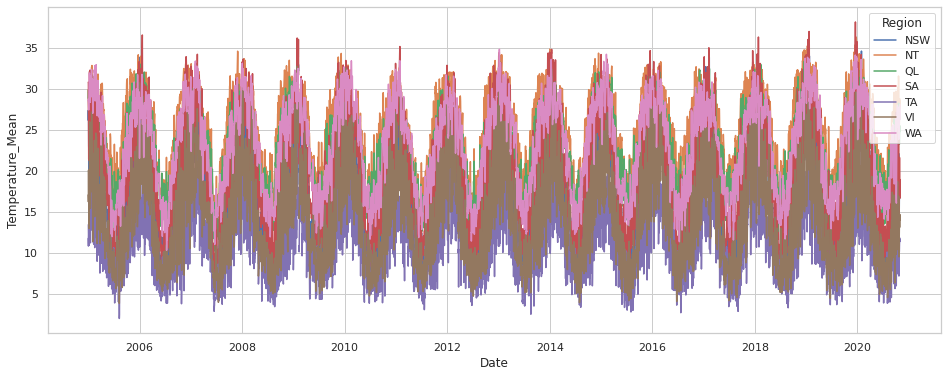

In [21]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Temperature_Mean",hue='Region', data=weather_data)

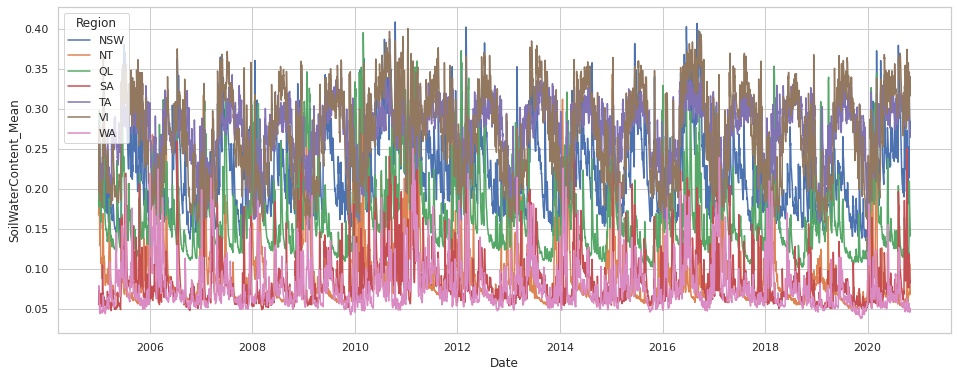

In [22]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="SoilWaterContent_Mean",hue='Region', data=weather_data)
#g = sns.lineplot(x="Date", y="SoilWaterContent_Min",hue='Region', data=weather_data)

<a class="anchor" id="data3"></a>
### 1.3 Historical Vegetation Index

The [Normalized difference vegetation index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) (NDVI) is a variable that is derived from sattelite images and is a measure for the greenness of the vegetation. The below is an example of what this looks like for Australia (mean vaules between 1 Dec 2012 to 31 May 2013).

![](https://upload.wikimedia.org/wikipedia/commons/1/18/NVDImapterrain2.png)

In [23]:
file_wildfires = "Nov_10/VegetationIndex.csv"
ndvi_df = pd.read_csv(file_wildfires)

# convert to datetime format
ndvi_df['Date'] = pd.to_datetime(ndvi_df['Date'])

print (ndvi_df.dtypes)
ndvi_df.head()

Region                               object
Date                         datetime64[ns]
Vegetation_index_mean               float64
Vegetation_index_max                float64
Vegetation_index_min                float64
Vegetation_index_std                float64
Vegetation_index_variance           float64
dtype: object


,Region,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,NSW,2005-01-01,0.349202,0.9972,-0.2,0.204862,0.041968
1,NSW,2005-02-01,0.357403,0.9772,-0.2,0.208673,0.043544
2,NSW,2005-03-01,0.354087,0.9750,-0.2,0.209450,0.043869
3,NSW,2005-04-01,0.347242,0.9904,-0.2,0.207307,0.042976
4,NSW,2005-05-01,0.345526,0.9972,-0.2,0.202858,0.041151


In [24]:
ndvi_df['Region'].unique()

array(['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'], dtype=object)

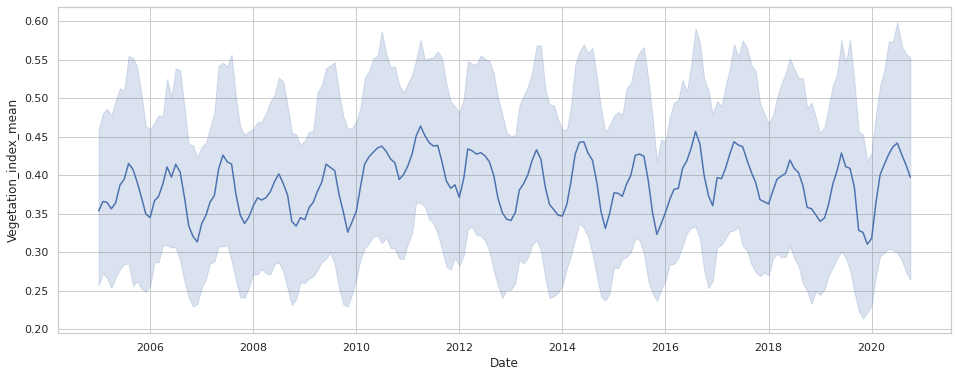

In [25]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Vegetation_index_mean", data=ndvi_df)

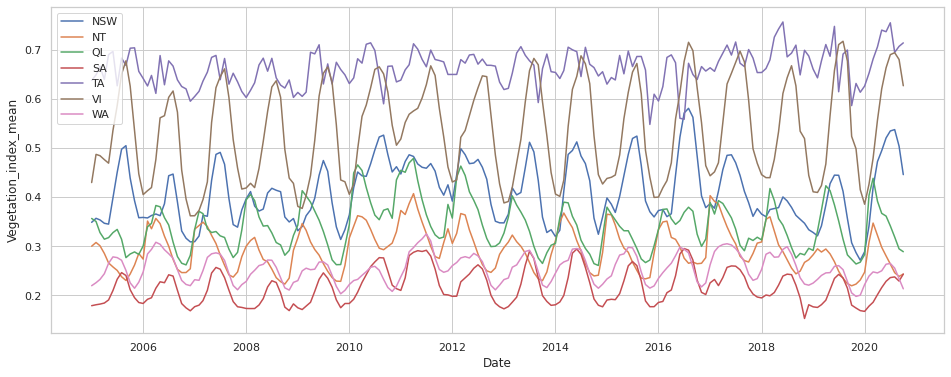

In [26]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
g = sns.lineplot(x="Date", y="Vegetation_index_mean",hue='Region', data=ndvi_df)
plt.legend(loc='best')

<a class="anchor" id="data4"></a>
### 1.4 Historical Weather Forecasts

This file contains the same variables as the above weather data, but these predicted forecasts and not observations. There is an extra column `Lead time` that gives the number of days the forecast is valid for. The below example explains this:

In [27]:
file_forecasts = "Nov_10/HistoricalWeatherForecasts.csv"
forecasts_df = pd.read_csv(file_forecasts)
forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])

forecasts_df.head()

,Date,Region,Parameter,Lead time,count()[unit: km^2],min(),max(),mean(),variance()
0,2014-01-01,NSW,RelativeHumidity,5,8.037682e+05,7.482927,85.021118,28.223569,353.620815
1,2014-01-01,NSW,SolarRadiation,5,8.037682e+05,24.865765,33.557598,31.647308,2.276068
2,2014-01-01,NSW,Temperature,5,8.037682e+05,21.243755,36.929035,30.893523,17.918553
3,2014-01-01,NSW,WindSpeed,5,8.037682e+05,1.593531,6.989559,3.958822,1.334834
4,2014-01-01,NT,RelativeHumidity,5,1.349817e+06,14.796251,73.601479,39.799856,189.805002


In [28]:
# check how many predictions there are for each day
forecasts_df['Lead time'].unique()

array([ 5, 10, 15])

In [29]:
# select data for one month in one region
d1 = '2020-01-01'
d2 ='2020-01-31'
r1 = 'NSW'

forecast1 = forecasts_df[(forecasts_df['Parameter']== 'Temperature') & (forecasts_df['Region']== r1)]
forecast1 = forecast1.set_index(['Date'])
forecast2 = forecast1.loc[d1:d2]
forecast2.head()

,Region,Parameter,Lead time,count()[unit: km^2],min(),max(),mean(),variance()
Date,,,,,,,,
2020-01-01,NSW,Temperature,5,803768.19762,16.968477,36.773914,28.557132,19.421144
2020-01-01,NSW,Temperature,10,803768.19762,17.254169,37.626869,30.319687,23.231273
2020-01-01,NSW,Temperature,15,803768.19762,13.469310,31.969305,25.005007,15.987917
2020-01-02,NSW,Temperature,5,803768.19762,17.931461,36.084873,28.821793,18.558279
2020-01-02,NSW,Temperature,10,803768.19762,22.026365,39.552299,32.804822,16.355089


In [30]:
# also find the observated weather for the same period
weather_data_NSW = weather_data[weather_data['Region']=='NSW']

weather_data_NSW = weather_data_NSW.set_index(['Date'])
obs1 = weather_data_NSW.loc[d1:d2]
obs1.head()

,Region,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,SoilWaterContent_Max,...,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NSW,3.668878,0.104289,0.0,0.146458,87.861794,30.291005,9.313578,386.401715,0.371896,...,20.980911,7.032370,37.017212,27.529635,14.403704,22.500503,6.587991,3.676050,1.145814,1.303046
2020-01-02,NSW,9.917132,0.253864,0.0,0.791259,91.251701,32.660449,7.294895,482.728062,0.373327,...,15.077473,8.872809,37.096256,28.886042,16.416523,22.007675,5.088723,3.265463,1.213501,0.574784
2020-01-03,NSW,1.681688,0.008512,0.0,0.005425,92.480141,27.166641,8.112389,317.563760,0.365096,...,26.110308,3.316400,39.985939,33.062747,19.849518,24.481774,7.190868,3.378213,1.395510,0.909916
2020-01-04,NSW,2.313565,0.065815,0.0,0.035870,74.164299,27.930265,14.596614,109.453610,0.354865,...,23.636795,3.551130,38.673840,31.853675,17.847557,19.003532,10.106893,4.620599,1.300415,3.281027
2020-01-05,NSW,10.003880,0.517439,0.0,0.956188,89.230743,45.874684,15.099000,329.066449,0.351612,...,8.245476,25.448863,36.978390,25.410221,10.446896,41.178617,8.764172,5.107051,1.278539,2.318480


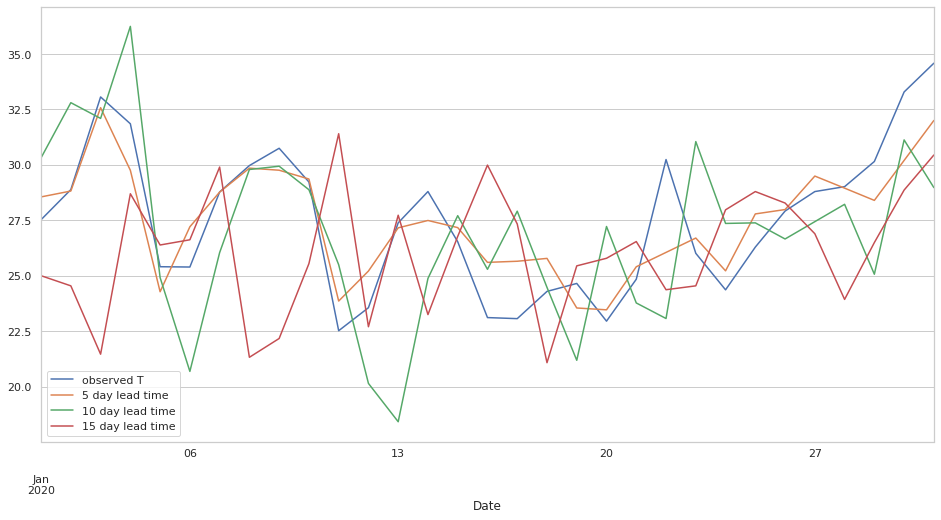

In [31]:
# compare them in a plot

[fig,ax] = plt.subplots(1, figsize=(16, 8))

obs1['Temperature_Mean'].plot();

forecast2['mean()'][forecast2['Lead time']== 5].plot();
forecast2['mean()'][forecast2['Lead time']== 10].plot();
forecast2['mean()'][forecast2['Lead time']== 15].plot();

ax.legend(['observed T','5 day lead time','10 day lead time','15 day lead time']);

### Back to the Future 

The historical weather forecast data will be key to building a model that predicts wildfire areas before they happen! 

<a class="anchor" id="exploration"></a>
## 2. Data Exploration

In this notebook the data is not checked for outliers or missing values.

>All data consists of timeseries that are aggregated over both time and space:
>* **Time**: daily values are derived from hourly and even shorter timesteps. The daily cycle of for instance temperature with cold nights and warm days will not be visible in the mean, but this can be dericed from the minimum and maximum that is also available in the dataset
>* **Space**: regional values are derived from large areas that are not homogenous at all, they contain forest, grassland and many more. To get an idea of this variation the `LandClass` data is provided that gives you the percentages of each vegetation type for the 7 regions.  

In [32]:
# merge historical fire and weather data into one DataFrame
df_all = wildfires_df.merge(weather_data, how='left', on=['Date', 'Region'])
df_all.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Estimated_fire_area,26406.0,144.297966,314.453847,1.000000,8.911875,3.843409e+01,146.951278,10120.943170
Mean_estimated_fire_brightness,26406.0,319.662078,8.862005,290.700000,313.933333,3.197844e+02,325.403144,381.950000
Mean_estimated_fire_radiative_power,26406.0,83.621258,67.510022,0.000000,44.150391,6.713333e+01,103.123611,2178.600000
Mean_confidence,26406.0,87.574735,4.371972,76.000000,85.000000,8.777143e+01,90.498403,100.000000
Std_confidence,24199.0,7.228302,1.995221,0.000000,6.687010,7.707025e+00,8.236665,16.970563
Var_confidence,24199.0,56.229092,25.898935,0.000000,44.716106,5.939823e+01,67.842642,288.000000
Count,26406.0,72.059305,150.973128,1.000000,5.000000,2.000000e+01,74.000000,3954.000000
Precipitation_Max,26402.0,18.003788,30.997624,0.000000,1.981011,7.096131e+00,20.573171,509.833069
Precipitation_Mean,26402.0,0.992475,2.049534,0.000000,0.031101,1.895815e-01,0.930820,27.747809
Precipitation_Min,26402.0,0.005322,0.089920,0.000000,0.000000,0.000000e+00,0.000000,4.023467


In [33]:
df_NSW = df_all[df_all['Region']=='NSW']
df_NSW.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,...,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,...,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,...,14.087289,29.763055,29.510120,22.425765,9.611800,13.352380,7.091141,4.014080,1.011328,1.043316
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,...,12.310518,22.667707,26.982698,20.621405,9.024039,11.764178,9.905821,4.477879,0.930842,1.953685
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,...,16.044561,6.949267,24.752069,19.632722,8.691216,7.940373,10.446799,4.017578,1.601724,1.102751
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,...,15.209880,27.822830,26.472469,21.477315,10.821342,12.063971,6.671862,3.884550,1.167861,0.774612


<a class="anchor" id="exp2"></a>
### 2.2 Data Distributions

<Figure size 864x864 with 0 Axes>

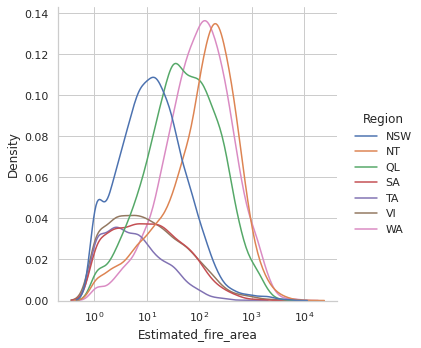

In [34]:
plt.figure(figsize=(12, 12));
sns.set(style="whitegrid")
#g = sns.displot(data=df_all, x="Estimated_fire_area", hue="Region", kind="kde");
g = sns.displot(data=df_all, x="Estimated_fire_area", hue="Region", kind="kde", log_scale=True);

<Figure size 864x864 with 0 Axes>

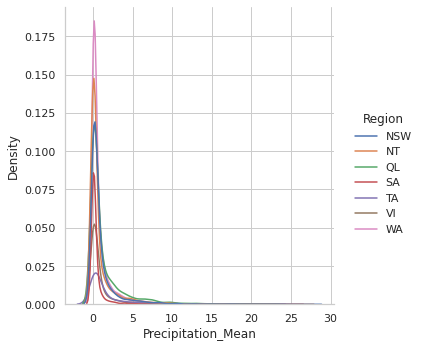

In [35]:
plt.figure(figsize=(12, 12));
sns.set(style="whitegrid")
g = sns.displot(data=df_all, x="Precipitation_Mean", hue="Region", kind="kde");

<Figure size 864x864 with 0 Axes>

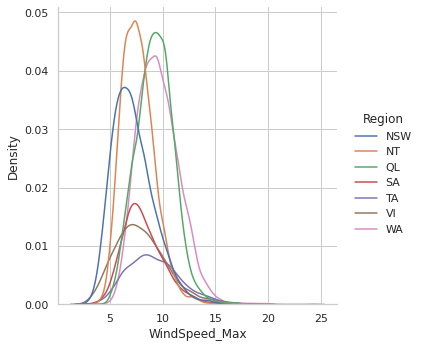

In [36]:
plt.figure(figsize=(12, 12));
sns.set(style="whitegrid")
g = sns.displot(data=df_all, x="WindSpeed_Max", hue="Region", kind="kde");

<a class="anchor" id="exp3"></a>
### 2.3 Correlations

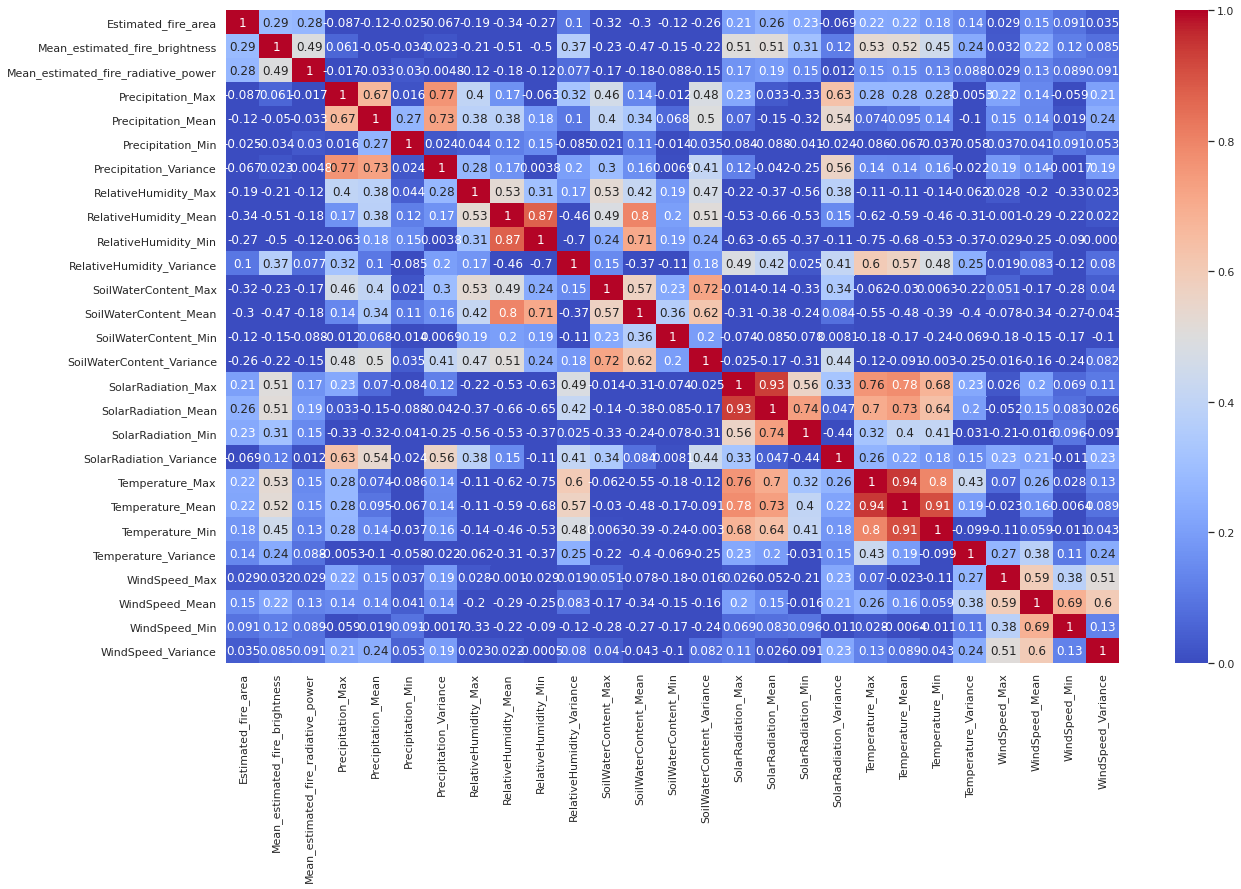

In [37]:
df_corr = df_all.drop(['Region', 'Date', 'Mean_confidence', 'Std_confidence', 'Var_confidence',
                            'Count', 'Replaced'], axis=1).copy()

plt.figure(figsize = (20, 12))
sns.heatmap(df_corr.corr(), cmap = "coolwarm", annot= True, vmin = 0, vmax = 1);

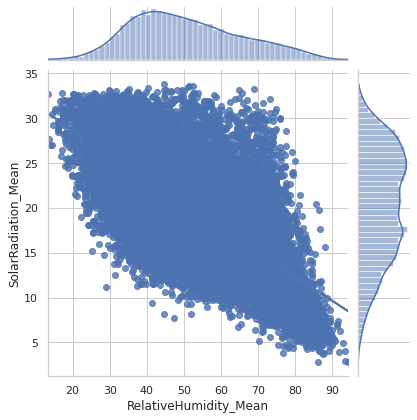

In [38]:
sns.jointplot(x='RelativeHumidity_Mean', y='SolarRadiation_Mean', data=df_all, kind="reg");

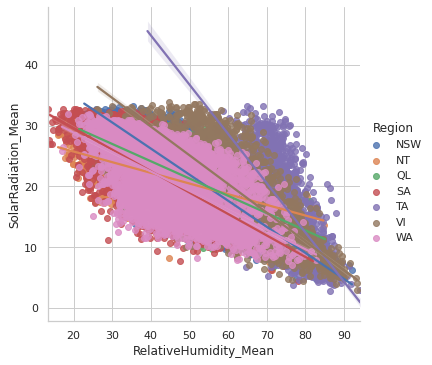

In [39]:
sns.lmplot(x='RelativeHumidity_Mean', y='SolarRadiation_Mean', hue='Region', data=df_all);

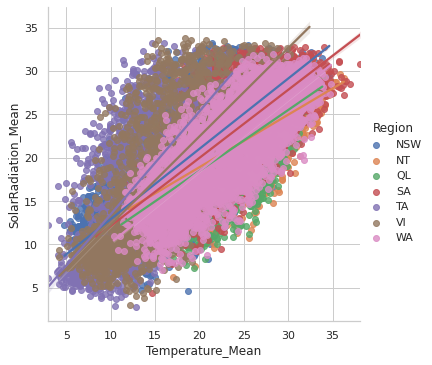

In [40]:
sns.lmplot(x='Temperature_Mean', y='SolarRadiation_Mean', hue='Region', data=df_all);

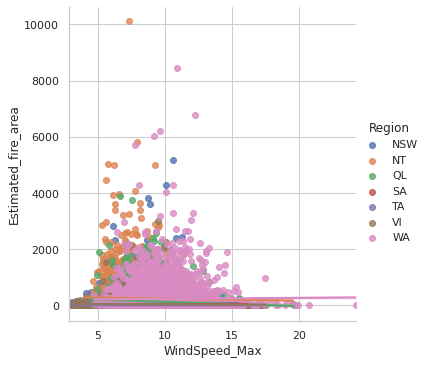

In [41]:
sns.lmplot(x='WindSpeed_Max', y='Estimated_fire_area', hue='Region', data=df_all);

<a class="anchor" id="predictions"></a>
## 3. Models


A linear regression model for one region to explore which variables are correlated with the wildfires. The goal of the challenge is to predict wildfires into the future, so you will need to use a range of data and the weather forecasts.

In [42]:
df_all2 = df_all[df_all['Region']=='NSW'].copy()
df_all2.drop_duplicates(inplace=True)
df_all2.reset_index(drop=True, inplace=True)
df_all2 = df_all2.dropna(how='any')

X = df_all2.drop(['Date','Estimated_fire_area','Region','Mean_confidence', 'Std_confidence',
                 'Var_confidence','Count','Replaced'],
                axis=1).copy()
y = df_all2['Estimated_fire_area'].copy()

In [43]:
# size of the data
df_all2.shape

(4051, 34)

In [44]:
# check for missing values
df_all2.isna().sum()

Region                                 0
Date                                   0
Estimated_fire_area                    0
Mean_estimated_fire_brightness         0
Mean_estimated_fire_radiative_power    0
Mean_confidence                        0
Std_confidence                         0
Var_confidence                         0
Count                                  0
Replaced                               0
Precipitation_Max                      0
Precipitation_Mean                     0
Precipitation_Min                      0
Precipitation_Variance                 0
RelativeHumidity_Max                   0
RelativeHumidity_Mean                  0
RelativeHumidity_Min                   0
RelativeHumidity_Variance              0
SoilWaterContent_Max                   0
SoilWaterContent_Mean                  0
SoilWaterContent_Min                   0
SoilWaterContent_Variance              0
SolarRadiation_Max                     0
SolarRadiation_Mean                    0
SolarRadiation_M

In [45]:
# one more quick check of the features
X.corr().style.background_gradient(cmap='coolwarm')

,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,SoilWaterContent_Max,SoilWaterContent_Mean,SoilWaterContent_Min,SoilWaterContent_Variance,SolarRadiation_Max,SolarRadiation_Mean,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance
Mean_estimated_fire_brightness,1.000000,0.442646,0.089368,0.022202,-0.031045,0.038731,-0.176265,-0.501825,-0.494783,0.450530,-0.035370,-0.364030,0.026731,-0.130872,0.571469,0.560743,0.397344,0.217168,0.566460,0.564107,0.520916,0.435140,0.014605,0.140584,0.127583,0.114130
Mean_estimated_fire_radiative_power,0.442646,1.000000,0.034846,-0.004331,-0.003981,0.008386,-0.051957,-0.166026,-0.138056,0.104567,-0.040461,-0.148532,-0.001719,-0.110585,0.159339,0.157879,0.113367,0.060606,0.175115,0.169309,0.141458,0.136003,0.021098,0.085722,0.057215,0.040805
Precipitation_Max,0.089368,0.034846,1.000000,0.735082,0.056778,0.745036,0.447129,0.221564,0.136150,0.150025,0.438723,0.225442,0.188893,0.266426,0.074036,-0.085220,-0.330855,0.561397,0.086586,0.092140,0.100010,-0.034846,0.184335,0.279460,0.131596,0.211497
Precipitation_Mean,0.022202,-0.004331,0.735082,1.000000,0.225382,0.725622,0.358777,0.303989,0.217681,0.022537,0.369087,0.327440,0.241051,0.126092,0.015170,-0.161190,-0.287452,0.447429,0.065472,0.071045,0.090811,-0.057239,0.123416,0.249757,0.102117,0.235628
Precipitation_Min,-0.031045,-0.003981,0.056778,0.225382,1.000000,0.038252,0.032582,0.079126,0.088783,-0.053800,0.031537,0.082106,0.061082,-0.054781,-0.051783,-0.060615,-0.048556,-0.008343,-0.024928,-0.017108,-0.003177,-0.045730,0.031536,0.061884,0.004627,0.067647
Precipitation_Variance,0.038731,0.008386,0.745036,0.725622,0.038252,1.000000,0.227465,0.152136,0.092236,0.096223,0.271539,0.192591,0.132885,0.162061,0.042855,-0.069844,-0.190258,0.450513,0.057008,0.064349,0.079797,-0.030940,0.122311,0.152380,0.067746,0.145734
RelativeHumidity_Max,-0.176265,-0.051957,0.447129,0.358777,0.032582,0.227465,1.000000,0.597654,0.498223,-0.037787,0.439127,0.396107,0.191621,0.296881,-0.340891,-0.478058,-0.660907,0.344083,-0.233916,-0.239221,-0.205287,-0.231718,0.030180,0.012901,-0.094233,-0.056397
RelativeHumidity_Mean,-0.501825,-0.166026,0.221564,0.303989,0.079126,0.152136,0.597654,1.000000,0.916219,-0.614782,0.396838,0.765947,0.280746,0.296564,-0.762187,-0.847087,-0.781373,-0.006043,-0.703125,-0.698338,-0.606501,-0.648748,-0.047408,-0.204683,-0.271066,-0.162705
RelativeHumidity_Min,-0.494783,-0.138056,0.136150,0.217681,0.088783,0.092236,0.498223,0.916219,1.000000,-0.769625,0.291596,0.708018,0.304720,0.110865,-0.751769,-0.809041,-0.698203,-0.116879,-0.693091,-0.681803,-0.603335,-0.649423,0.042597,-0.119538,-0.178544,-0.120110
RelativeHumidity_Variance,0.450530,0.104567,0.150025,0.022537,-0.053800,0.096223,-0.037787,-0.614782,-0.769625,1.000000,0.016056,-0.514466,-0.184187,0.094507,0.606675,0.594451,0.350601,0.367744,0.637016,0.625817,0.578812,0.630697,-0.124111,0.021114,-0.003984,0.075687


<a class="anchor" id="model1"></a>
### 3.1 Linear regression model

In [46]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# create linear regression object
regr = linear_model.LinearRegression()

# train the model using the training data
regr.fit(X_train, y_train)

# make predictions using the test data
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination (r2): %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [-1.49864129e-01  5.56653945e-01  2.63990169e-01  4.35203295e+00
 -9.87709462e+01  6.85488412e-02  2.82437828e+00 -2.75570178e+00
 -2.00867525e-01 -3.40354422e-01 -4.03078779e+02  1.65996630e+02
 -1.63761080e+03 -2.57117900e+03 -6.31838838e+00  7.42019593e+00
 -5.89170695e-01  5.36035881e-02 -6.72548529e-01  1.35642431e+01
 -1.10569387e+01  5.49536079e-01  3.13394558e+00  1.49575633e+01
 -4.80322334e+01 -1.68231067e+01]
RMSE: 221.28
Coefficient of determination (r2): 0.11


In [47]:
# normalize the data
scaler = StandardScaler().fit(X_train)

X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training data
regr.fit(X_train2, np.log(y_train))

# Make predictions using the test data
y_pred = regr.predict(X_test2)

print('Coefficients: \n', regr.coef_)
print('RMSE: %.2f' % np.sqrt(mean_squared_error(np.log(y_test), y_pred)))
print('Coefficient of determination (r2): %.2f' % r2_score(np.log(y_test), y_pred))

Coefficients: 
 [-0.04592253  0.49449361  0.01700134  0.00616261 -0.01895765  0.06376674
  0.02166007 -0.08606667 -0.23508429 -0.24849387 -0.04101943 -0.35112408
  0.03096199 -0.08057969 -1.06726052  0.69597497 -0.02688283  0.12020455
  0.16120555  0.03710044  0.01582056 -0.0603015   0.0273023   0.10008341
 -0.0822503  -0.05024538]
RMSE: 1.08
Coefficient of determination (r2): 0.31


<a class="anchor" id="model2"></a>
### 3.2 Decision tree model

In [48]:
tree = DecisionTreeRegressor(max_depth=3,random_state=42)
tree.fit(X_train2, np.log(y_train))
tree_pred = tree.predict(X_test2)

print(tree.feature_importances_)

print('RMSE: %.2f' % np.sqrt(mean_squared_error(np.log(y_test), tree_pred)))
print('Coefficient of determination (r2): %.2f' % r2_score(np.log(y_test), tree_pred))

[0.         0.82110467 0.         0.         0.         0.
 0.         0.         0.         0.         0.02240554 0.15648979
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
RMSE: 1.02
Coefficient of determination (r2): 0.40


In [49]:
values = tree.feature_importances_
keys = X_train.columns 

importance = {keys[i]: values[i] for i in range(len(keys))}
importance

{'Mean_estimated_fire_brightness': 0.0,
 'Mean_estimated_fire_radiative_power': 0.8211046673311773,
 'Precipitation_Max': 0.0,
 'Precipitation_Mean': 0.0,
 'Precipitation_Min': 0.0,
 'Precipitation_Variance': 0.0,
 'RelativeHumidity_Max': 0.0,
 'RelativeHumidity_Mean': 0.0,
 'RelativeHumidity_Min': 0.0,
 'RelativeHumidity_Variance': 0.0,
 'SoilWaterContent_Max': 0.02240554429073428,
 'SoilWaterContent_Mean': 0.1564897883780885,
 'SoilWaterContent_Min': 0.0,
 'SoilWaterContent_Variance': 0.0,
 'SolarRadiation_Max': 0.0,
 'SolarRadiation_Mean': 0.0,
 'SolarRadiation_Min': 0.0,
 'SolarRadiation_Variance': 0.0,
 'Temperature_Max': 0.0,
 'Temperature_Mean': 0.0,
 'Temperature_Min': 0.0,
 'Temperature_Variance': 0.0,
 'WindSpeed_Max': 0.0,
 'WindSpeed_Mean': 0.0,
 'WindSpeed_Min': 0.0,
 'WindSpeed_Variance': 0.0}

<a class="anchor" id="next"></a>
## 4. Next steps

### Things to think about

* Check for missing values and outliers
* Correlation between features, for instance between temperature and relative humidity
* Lag effects, you can think of SWC as the 'memory' of the system
* Explore some timeseries models, and how to use the forecast data to predict values a month ahead
* Data is aggregated over a large area, how will this impact each feature? 
* Do a brainstorm of how you think wildfires get started and how they spread, this can help with adding additional features
* Use the forecast weather data to think about how you could build a model to predict the wildfires for February with observations only availabe until the end of January

### Signup for the competition

* Form a team
* Explore the data with the materials in [this GitHub repo](https://github.com/Call-for-Code/Spot-Challenge-Wildfires)
* Attend additional seminars
* Find more details and how to sign up for the competition [here](http://ibm.biz/cfcsc-wildfires)
* Build your model
* Submit your predictions

* Ask me (Margriet) questions in the #cfcsc-wildfires [Call for Code Slack channel](http://callforcode.slack.com)

